## Global Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from numpy.random import seed
seed(10)

## Load Data

In [2]:
!ls

 Compare_All_Precision-Recall.png  'MLP CV.png'
 Compare_All_ROC.png		    sample_data
 cvAuROC.png			   'XGBoost CV.png'
'ET CV.png'			   'XGBoost ROC(Cross val and Independent).png'
 Full_Meth_pssm+spd_dataset.csv


In [3]:
fileName = 'Full_Meth_pssm+spd_dataset.csv'
dataset = pd.read_csv(fileName, header=None, engine='python')
dataset.shape

(26673, 267)

In [4]:
dataset.head(5)

,0,1,2,3,4,5,6,7,8,9,...,257,258,259,260,261,262,263,264,265,266
0,25.0,-7.6200,25.0,-4.070,10.70,25.0,-2.06,1.860,15.2,25.0,...,1.28,-2.86,-9.22,-3.77,-7.13,-15.3,3.27,-24.9,-2.86,1
1,25.0,-10.2000,25.0,-11.200,11.20,25.0,-6.07,3.550,16.3,25.0,...,1.02,-2.11,-6.74,22.60,-17.80,-19.9,-10.20,-25.0,-2.11,1
2,25.0,-5.7900,25.0,2.110,9.63,25.0,1.36,4.580,20.4,25.0,...,4.55,-14.90,-8.79,-1.86,-9.69,-23.0,-4.15,-22.4,-14.90,1
3,25.0,-1.4900,25.0,-0.941,8.97,25.0,-2.13,1.880,16.0,25.0,...,-9.13,-14.40,-4.10,6.81,-15.40,-21.7,9.28,-13.7,-14.40,1
4,25.0,-0.0711,25.0,-4.850,9.32,25.0,-5.97,-0.816,16.4,25.0,...,6.42,-9.81,-13.20,19.30,-15.00,-17.6,2.15,-24.7,-9.81,1


In [5]:
dataset.isnull().any().any()

True

In [6]:
dataset.fillna(1, inplace=True)

In [7]:
dataset.isnull().any().any()

False

In [8]:
shortCol = []
columns = dataset.columns.tolist()
for i in columns:
  if(dataset[i].nunique() != 1):
    shortCol.append(i)
    #print(i, ": ", dataset[i].nunique())

In [9]:
ttl_data = dataset.iloc[:, shortCol].values
np.random.shuffle(ttl_data)
ttl_data.shape

(26673, 266)

In [10]:
ttl_data[ttl_data[:, -1] == 1].shape

(12646, 266)

In [11]:
ttl_data[ttl_data[:, -1] == 0].shape

(14027, 266)

## Separate Positives & Negatives

In [12]:
pos = ttl_data[ttl_data[:, -1] == 1]
np.random.shuffle(pos)
neg = ttl_data[ttl_data[:, -1] == 0]
np.random.shuffle(neg)

## Train-Test Split

In [13]:
tstSize = 5335
p_test, p_train = pos[0:tstSize, ...], pos[tstSize:, ...]
n_test, n_train = neg[0:tstSize, ...], neg[tstSize:, ...]
train, test = np.vstack((p_train, n_train)), np.vstack((p_test, n_test))
np.random.shuffle(train)
np.random.shuffle(test)
X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]

In [14]:

print(y_train.shape)
print(y_train[y_train == 1].shape)
print(y_train[y_train == 0].shape)

print('-'*60)

print(y_test.shape)
print(y_test[y_test == 1].shape)
print(y_test[y_test == 0].shape)

(16003,)
(7311,)
(8692,)
------------------------------------------------------------
(10670,)
(5335,)
(5335,)


## Scaling Data

In [15]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

## Balance Data

In [16]:
### direct undersampling ###

# tstSize = 100
# p_test, p_train = pos[0:tstSize, ...], pos[tstSize:, ...]
# n_test, n_train = neg[0:tstSize, ...], neg[tstSize:tstSize+p_train.shape[0], ...]
# train, test = np.vstack((p_train, n_train)), np.vstack((p_test, n_test))
# np.random.shuffle(train)
# np.random.shuffle(test)
# X_train, X_test, y_train, y_test = train[:, :-1], test[:, :-1], train[:, -1], test[:, -1]

In [17]:
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='auto')
# #tl = TomekLinks(sampling_strategy='all')
# X_train_res, y_train_res = tl.fit_resample(X_train, y_train)

In [18]:
# from imblearn.over_sampling import SVMSMOTE
# X_train_res, y_train_res = SVMSMOTE().fit_resample(X_train_res, y_train_res)

In [19]:
# from imblearn.under_sampling import ClusterCentroids
# X_train_res, y_train_res = ClusterCentroids(sampling_strategy='auto').fit_resample(X_train, y_train)

In [20]:
from imblearn.combine import SMOTETomek
X_train_res, y_train_res = SMOTETomek(random_state=42).fit_resample(X_train, y_train)

In [21]:
# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks(sampling_strategy='all')
# X_train_res, y_train_res = tl.fit_resample(X_train_res, y_train_res)

In [22]:
print(y_train_res.shape)
print(y_train_res[y_train_res == 1].shape)
print(y_train_res[y_train_res == 0].shape)

(16550,)
(8275,)
(8275,)


## Trial SVM


In [23]:
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

regr = SVR(kernel='rbf', gamma='scale', C=1.0, epsilon=0.2)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = SVC(kernel='rbf', C=1.0, gamma='scale')

clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.8266166822867854

f1_score:  0.8057538849223015

Confusion Matrix
[[4983  352]
 [1498 3837]]
------------------------------------------------------------
accuracy:  0.8252108716026242

f1_score:  0.8008967652396711

Confusion Matrix
[[5054  281]
 [1584 3751]]


## XGBoost

In [24]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

regr = XGBRegressor(n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

regr = XGBRFRegressor(n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = XGBClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = XGBRFClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

[12:43:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
accuracy:  0.8278350515463917

f1_score:  0.8088250598397336

Confusion Matrix
[[4947  388]
 [1449 3886]]
------------------------------------------------------------
[12:44:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
accuracy:  0.7910965323336457

f1_score:  0.7526905580827694

Confusion Matrix
[[5049  286]
 [1943 3392]]
------------------------------------------------------------
accuracy:  0.8298969072164949

f1_score:  0.813597617335935

Confusion Matrix
[[4894  441]
 [1374 3961]]
------------------------------------------------------------
accuracy:  0.791377694470478

f1_score:  0.7529960053262317

Confusion Matrix
[[5051  284]
 [1942 3393]]


## AdaBoost

In [25]:
from sklearn.ensemble import AdaBoostClassifier

boost = AdaBoostClassifier(n_estimators=300)
boost.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.791377694470478

f1_score:  0.7529960053262317

Confusion Matrix
[[5051  284]
 [1942 3393]]


## RandomForest

In [26]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=300)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = RandomForestClassifier(max_depth=2, random_state=0, n_estimators=300)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.7901593252108716

f1_score:  0.7448433048433047

Confusion Matrix
[[5163  172]
 [2067 3268]]
------------------------------------------------------------
accuracy:  0.758950328022493

f1_score:  0.6826258637709773

Confusion Matrix
[[5332    3]
 [2569 2766]]


##MLP neural_network

In [27]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(alpha=1, max_iter=1000)
#clf = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
clf.fit(X_train, y_train)


from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84652568 0.83685801 0.84592145 0.8489426  0.83504532 0.84773414
 0.83383686 0.82537764 0.85256798 0.85075529]
accuracy:  0.842356495468278
0.00849560579708459


In [28]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.823805060918463

f1_score:  0.7990594271056007

Confusion Matrix
[[5052  283]
 [1597 3738]]


## LightGBM

In [29]:
from lightgbm import LGBMRegressor, LGBMClassifier

regr = LGBMRegressor(num_leaves=31, n_estimators=40, learning_rate=0.1)
regr.fit(X_train_res, y_train_res)

y_pred = regr.predict(X_test)
y_pred = np.where(y_pred > 0.50, 1, 0)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

print('-'*60)

clf = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1)
clf.fit(X_train_res, y_train_res)

y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

accuracy:  0.8238987816307404

f1_score:  0.8039236147344256

Confusion Matrix
[[4939  396]
 [1483 3852]]
------------------------------------------------------------
accuracy:  0.8252108716026242

f1_score:  0.8073546121268464

Confusion Matrix
[[4897  438]
 [1427 3908]]


In [30]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8252108716026242

f1_score:  0.8073546121268464

Confusion Matrix
[[4897  438]
 [1427 3908]]


##ExtraTrees

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84350453 0.83021148 0.85256798 0.83685801 0.83504532 0.83685801
 0.84471299 0.83806647 0.88096677 0.89848943]
accuracy:  0.849728096676737
0.02118779172186911


In [32]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8039362699156514

f1_score:  0.7743257820927724

Confusion Matrix
[[4989  346]
 [1746 3589]]


##SVM

In [33]:
from sklearn.svm import SVC, SVR

classifier = SVC(kernel='rbf', C=1.0, gamma='scale')
classifier.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84169184 0.83444109 0.8489426  0.84954683 0.82598187 0.83202417
 0.83141994 0.83141994 0.84108761 0.83987915]
accuracy:  0.8376435045317221
0.007469265375331266


In [34]:
y_pred = classifier.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8252108716026242

f1_score:  0.8008967652396711

Confusion Matrix
[[5054  281]
 [1584 3751]]


##XGBOOST

In [35]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

clf = XGBClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

print('-'*60)

clf = XGBRFClassifier(n_estimators=300)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())



***CROSS VALIDATION***
[0.84531722 0.83927492 0.85498489 0.84229607 0.83746224 0.84531722
 0.83625378 0.83504532 0.85740181 0.86042296]
accuracy:  0.8453776435045317
0.008732947048057459
------------------------------------------------------------
***CROSS VALIDATION***
[0.80060423 0.79758308 0.82114804 0.81450151 0.78912387 0.79456193
 0.8        0.80241692 0.80543807 0.79818731]
accuracy:  0.8023564954682779
0.008914997825295585


In [36]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.791377694470478

f1_score:  0.7529960053262317

Confusion Matrix
[[5051  284]
 [1942 3393]]


##LightGBM

In [37]:
from lightgbm import LGBMRegressor, LGBMClassifier

clf = LGBMClassifier(num_leaves=31, n_estimators=40, learning_rate=0.1)
clf.fit(X_train_res, y_train_res)

from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = clf, X = X_train_res, y = y_train_res, cv = 10)
print("***CROSS VALIDATION***")
print(accuracies)
print("accuracy: ", accuracies.mean())
print(accuracies.std())

***CROSS VALIDATION***
[0.84773414 0.83323263 0.84712991 0.83927492 0.82296073 0.83564955
 0.83746224 0.83625378 0.85861027 0.85135952]
accuracy:  0.8409667673716014
0.0097608800030495


In [38]:
y_pred = clf.predict(X_test)

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
acc = accuracy_score(y_test, y_pred)
print("***INDEPENDENT TEST***")
print("accuracy: ", acc)
print()

f1 = f1_score(y_test, y_pred, average='binary')
print("f1_score: ", f1)
print()

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix")
print(cm)

***INDEPENDENT TEST***
accuracy:  0.8252108716026242

f1_score:  0.8073546121268464

Confusion Matrix
[[4897  438]
 [1427 3908]]


## Init Scorers

In [39]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef
from imblearn.metrics import sensitivity_score, specificity_score

curves = []

def plt_curve(lst, name):
  plt.figure(figsize=(8,6))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    plt.plot(fpr, tpr, lw=1, linestyle='--', label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
    
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

## SVM CV Scores

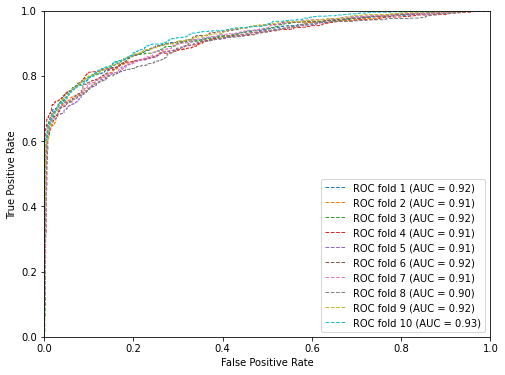

***CROSS VALIDATION***
SVM


{'fit_time': array([159.34402561, 158.35586834, 159.99258876, 158.17997289,
        157.94131041, 155.65534902, 157.32165313, 154.73177624,
        157.62139249, 158.43663239]),
 'score_time': array([5.76203585, 5.68638539, 5.79963255, 5.51849866, 6.2224102 ,
        5.55057931, 5.39171886, 5.73017859, 5.71766448, 5.8547492 ]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.7012908 , 0.68487566, 0.71197495, 0.71448148, 0.67101354,
        0.68231897, 0.67715009, 0.67785777, 0.70284132, 0.69744976]),
 'test_sensitivity_score': array([0.72914148, 0.7267231 , 0.7496977 , 0.74607013, 0.70737606,
        0.7173913 , 0.7294686 , 0.72705314, 0.72101449, 0.72826087]),
 'test_specificity_score': array([0.95410628, 0.94202899, 0.94806763, 0.95289855, 0.94444444,
        0.94679565, 0.93349456, 0.93591294, 0.96130593, 0.95163241])}

In [40]:
from sklearn.svm import SVC, SVR
classifier = SVC(kernel='rbf', probability=True, C=1.0, gamma='scale')


curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "SVM CV")
print("***CROSS VALIDATION***")
print("SVM")
scores
#scores['roc']=curves

## XGBoost CV Scores

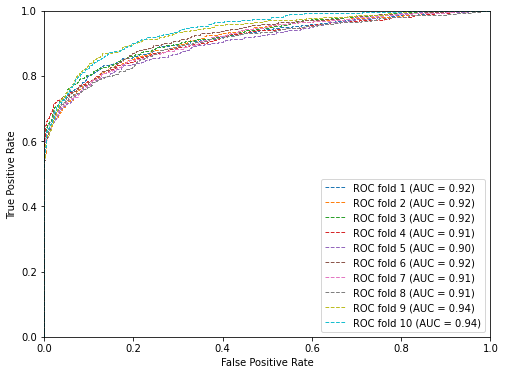

***CROSS VALIDATION***
XGBoost


{'fit_time': array([45.07073975, 45.07639623, 44.67908072, 44.66235924, 45.46795774,
        44.91199207, 45.22787452, 45.53545213, 43.12421227, 42.41176033]),
 'score_time': array([0.05182314, 0.05181575, 0.05169034, 0.05259418, 0.05162549,
        0.05122757, 0.05173373, 0.05048394, 0.0512116 , 0.05135226]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.699564  , 0.68963713, 0.71630436, 0.68932262, 0.68273046,
        0.69880971, 0.67822594, 0.67894768, 0.72299123, 0.72608021]),
 'test_sensitivity_score': array([0.76541717, 0.7496977 , 0.78839178, 0.78355502, 0.7617896 ,
        0.76932367, 0.77173913, 0.75483092, 0.7826087 , 0.80072464]),
 'test_specificity_score': array([0.92512077, 0.92874396, 0.92149758, 0.90096618, 0.91304348,
        0.92140266, 0.90084643, 0.91535671, 0.93228537, 0.92019347])}

In [ ]:
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
classifier = XGBClassifier(n_estimators=300)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "XGBoost CV")
print("***CROSS VALIDATION***")
print("XGBoost")
scores
#scores['roc']=curves

## ET CV Scores

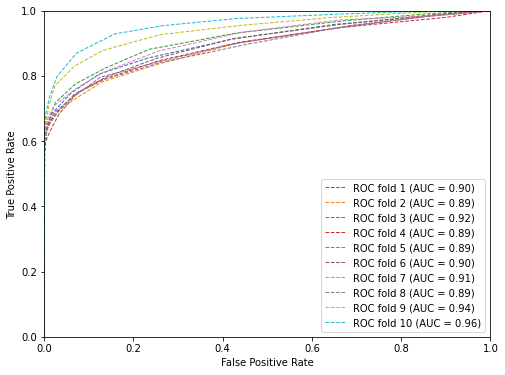

***CROSS VALIDATION***
ET


{'fit_time': array([0.47612977, 0.46136999, 0.45943475, 0.45680404, 0.46403766,
        0.46097064, 0.47072363, 0.46610355, 0.46321273, 0.45645571]),
 'score_time': array([0.02135134, 0.02039838, 0.02094054, 0.02050066, 0.02100158,
        0.02023458, 0.02065372, 0.02150059, 0.02027965, 0.02171063]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.70001946, 0.67566544, 0.71369986, 0.68630762, 0.68592702,
        0.6844864 , 0.6996878 , 0.68884025, 0.76580936, 0.79833   ]),
 'test_sensitivity_score': array([0.74727932, 0.72430472, 0.77509069, 0.74123337, 0.72793229,
        0.74879227, 0.75966184, 0.74275362, 0.83091787, 0.86956522]),
 'test_specificity_score': array([0.93961353, 0.93599034, 0.92995169, 0.93236715, 0.94202899,
        0.92503023, 0.92986699, 0.93349456, 0.93107618, 0.92744861])}

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
classifier = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "ET CV")
print("***CROSS VALIDATION***")
print("ET")
scores
#scores['roc']=curves

##MLP CV

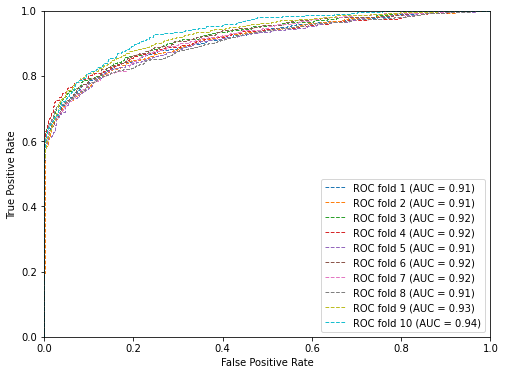

***CROSS VALIDATION***
MLP


{'fit_time': array([16.92985153, 15.07187057, 10.95851064, 13.89027023, 17.18120694,
        15.68256593, 20.56498051, 11.7480092 , 13.01761937, 19.98229098]),
 'score_time': array([0.01926374, 0.01909781, 0.01889157, 0.01797628, 0.01834488,
        0.01834035, 0.01803756, 0.01777148, 0.01925349, 0.01925683]),
 'test_roc_plt': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'test_matthews_corrcoef': array([0.69529726, 0.67702902, 0.68582587, 0.70617727, 0.66930737,
        0.68116905, 0.66625348, 0.67515689, 0.71478375, 0.71239325]),
 'test_sensitivity_score': array([0.77267231, 0.78718259, 0.79927449, 0.80169287, 0.7617896 ,
        0.80797101, 0.80555556, 0.79227053, 0.78985507, 0.77536232]),
 'test_specificity_score': array([0.91545894, 0.88647343, 0.88405797, 0.90096618, 0.90096618,
        0.87182588, 0.85973398, 0.88029021, 0.91898428, 0.9286578 ])}

In [ ]:
from sklearn.neural_network import MLPClassifier
classifier = MLPClassifier(alpha=1, max_iter=1000)

curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=False)

plt_curve(curves, "MLP CV")
print("***CROSS VALIDATION***")
print("MLP")
scores
#scores['roc']=curves

## ROC Comparisons of all Estimators and Average Precision

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(8,6))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0

  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, linestyle='--', color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  #plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(8,6))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=2, linestyle='--', label='Precision-Recall fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }


***Independent Test***
matthews_corrcoef for SVM:  0.6707344130254801

sensitivity_score for SVM:  0.7030927835051546

specificity_score for SVM:  0.9473289597000937

***Independent Test***
matthews_corrcoef for ET:  0.6299495648841305

sensitivity_score for ET:  0.6727272727272727

specificity_score for ET:  0.93514526710403

***Independent Test***
matthews_corrcoef for MLP:  0.6695073685234204

sensitivity_score for MLP:  0.7192127460168697

specificity_score for MLP:  0.9345829428303655

***Independent Test***
matthews_corrcoef for XGBoost:  0.6701208805166733

sensitivity_score for XGBoost:  0.7424554826616683

specificity_score for XGBoost:  0.9173383317713215



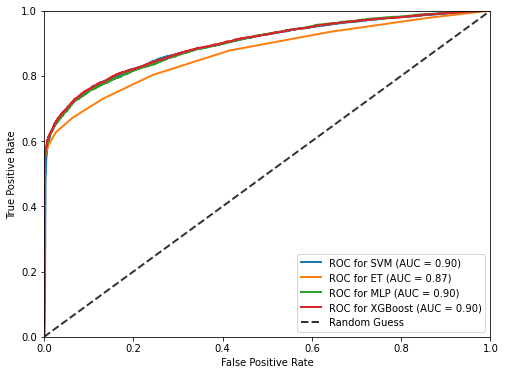

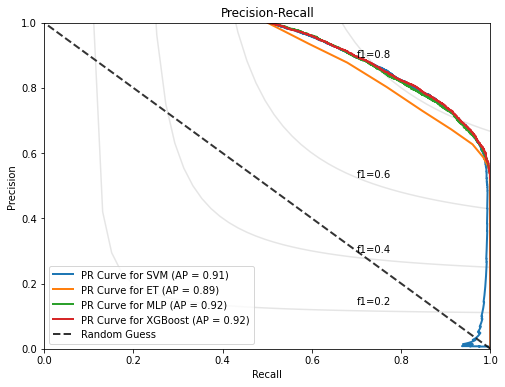

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier


estimators = {"SVM": SVC(kernel='rbf', probability=True, gamma='scale'),
              "ET": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
              "MLP": MLPClassifier(alpha=1, max_iter=1000),
              "XGBoost": XGBClassifier(n_estimators=300)}

probas_pred = []
avg_pre = []

plt.figure(figsize=(8,6))

for key, clf in estimators.items():
  clf.fit(X_train_res, y_train_res)
  y_pred = clf.predict(X_test)
  y_score = clf.predict_proba(X_test)
  probas_pred.append(y_score)
  avg_pre.append(average_precision_score(y_test, y_score[:, 1], pos_label=1))

  fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(fpr, tpr, lw=2, label='ROC for %s (AUC = %0.2f)' % (key, auc(fpr, tpr)))
  print("***Independent Test***")
  mat_cor_coef = matthews_corrcoef(y_test, y_pred)
  print("matthews_corrcoef for " + key + ": ", mat_cor_coef)
  print()

  sen_scr = sensitivity_score(y_test, y_pred)
  print("sensitivity_score for " + key + ": ", sen_scr)
  print()

  spe_scr = specificity_score(y_test, y_pred)
  print("specificity_score for " + key + ": ", spe_scr)
  print()
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)   
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "Compare_All_ROC" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


plt.figure(figsize=(8,6))

f_scores = np.linspace(0.2, 0.8, num=4)
for f_score in f_scores:
  x = np.linspace(0.01, 1)
  y = f_score * x / (2 * x - f_score)
  l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
  plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))

keyZ = list(estimators.keys())
for idx, y_score in enumerate(probas_pred):
  pre, rec, _ = precision_recall_curve(y_test, y_score[:, 1], pos_label=1)
  
  plt.plot(pre, rec, lw=2, label='PR Curve for %s (AP = %0.2f)' % (keyZ[idx], avg_pre[idx]))
plt.plot([1, 0], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)  
plt.ylim([0.0, 1.0])
plt.xlim([0.0, 1.0])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall')
plt.legend(loc="lower left")
figName = "Compare_All_Precision-Recall" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()

## Cross Validation and Independent Test for (SVM)

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
import numpy as np 

tprs = []
def plt_curve(lst, name):
  plt.figure(figsize=(8,6))
  
  for idx, itm in enumerate(lst):
    fpr, tpr = itm
    tprs.append(interp(np.linspace(0, 1, 100), fpr, tpr))
    tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
  plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Random Guess', alpha=.8)

  mean_tpr = np.float64(1.0)
  mean_tpr = np.mean(tprs, axis=0)
  mean_tpr[-1] = 1.0
  mean_auc = auc(np.linspace(0, 1, 100), mean_tpr)
  std_auc = np.std(aucs)
  plt.plot(mean_fpr, mean_tpr, color='b',
         label='% fold cross validation (AUC = %0.2f)' % (mean_auc),
         lw=2, alpha=.8)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
 # plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def roc_plt(y_true, y_score):
  fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=1)
  curves.append([fpr, tpr])
  return 1

def pr_curve(lst, apLst, name):
  plt.figure(figsize=(8,6))
  
  f_scores = np.linspace(0.2, 0.8, num=4)
  for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', linestyle='--', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.7, y[36] + 0.02))
  
  for idx, itm in enumerate(lst):
    pre, rec = itm
    plt.plot(pre, rec, lw=1, linestyle='--', label='PR fold %d (AP = %0.2f)' % (idx+1, apLst[idx]))
    
  plt.ylim([0.0, 1.0])
  plt.xlim([0.0, 1.0])
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall')
  plt.legend(loc="lower right")
  figName = name + '.png'
  plt.savefig(figName, bbox_inches='tight')
  plt.show()

  
  
def pr_plt(y_true, y_score):
  precision, recall, _ = precision_recall_curve(y_true, y_score, pos_label=1)
  pr_curves.append([precision, recall])
  return 1

metrs = {
         'roc_plt': make_scorer(roc_plt, needs_proba=True), 
         'pr_plt': make_scorer(pr_plt, needs_proba=True), 
         'average_precision': make_scorer(average_precision_score, needs_proba=True), 
         'matthews_corrcoef': make_scorer(matthews_corrcoef), 
         'sensitivity_score': make_scorer(sensitivity_score), 
         'specificity_score': make_scorer(specificity_score)
        }

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


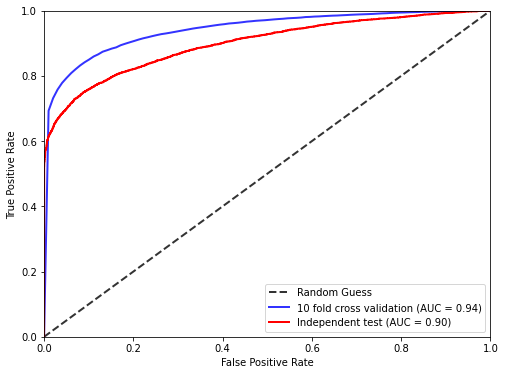

In [ ]:
from sklearn.svm import SVC, SVR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import seed
seed(10)
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn import datasets 

from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor

classifier = XGBClassifier(n_estimators=300)


#classifier = SVC(kernel='rbf', probability=True, gamma='scale')

curves = []
pr_curves = []

scores = cross_validate(classifier, 
                        X_train_res, 
                        y_train_res, 
                        cv=10,
                        scoring=metrs,
                        return_train_score=True)


tprs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8,6))

for idx, itm in enumerate(curves):
  fpr, tpr = itm
  tprs.append(interp(mean_fpr, fpr, tpr))
  tprs[-1][0] = 0.0
#     plt.plot(fpr, tpr, lw=1, label='ROC fold %d (AUC = %0.2f)' % (idx+1, auc(fpr, tpr)))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
       label='Random Guess', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
#mean_tpr[mean_tpr > 1] = 1

mean_auc = auc(mean_fpr, mean_tpr) 
plt.plot(mean_fpr, mean_tpr, color='b', label='10 fold cross validation (AUC = %0.2f)' % (mean_auc), lw=2, alpha=.8)
classifier.fit(X_train_res, y_train_res)
y_pred = classifier.predict(X_test)
y_score = classifier.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1], pos_label=1)
plt.plot(fpr, tpr, lw=2, color='r', label='Independent test (AUC = %0.2f)' % (auc(fpr, tpr)))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
#plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
figName = "XGBoost ROC(Cross val and Independent)" + '.png'
plt.savefig(figName, bbox_inches='tight')
plt.show()


##Cross Validation Curve

In [ ]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBClassifier, XGBRegressor, XGBRFClassifier, XGBRFRegressor
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, auc, matthews_corrcoef, precision_recall_curve, average_precision_score
from imblearn.metrics import sensitivity_score, specificity_score
from scipy import interp

def auROCplot():
    ### auROC ###
    plt.figure(figsize=(8,6))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Random')
    plt.xlim([0.0, 1.00])
    plt.ylim([0.0, 1.02])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    # plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc='lower right')

    plt.savefig('cvAuROC.png')
    plt.show()
    ### --- ###

    
def runAll(X, y):
    Names = []
    Classifiers = []
    estimators = {"SVM": SVC(kernel='rbf', gamma='scale', probability=True),
                  "ET": ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
                  "MLP": MLPClassifier(alpha=1, max_iter=1000),
                  "XGBoost": XGBClassifier(n_estimators=300)}

    for key, value in estimators.items():
        Names.append(key)
        Classifiers.append(value)

    Results = []  # compare algorithms

    from sklearn.metrics import accuracy_score, \
        confusion_matrix, \
        roc_auc_score,\
        average_precision_score,\
        roc_curve, f1_score, recall_score, matthews_corrcoef, auc

    # Step 05 : Spliting with 10-FCV :
    from sklearn.model_selection import StratifiedKFold

    cv = StratifiedKFold(n_splits=10, shuffle=True)

    for classifier, name in zip(Classifiers, Names):

        accuray = []
        auROC = []
        avePrecision = []
        F1_Score = []
        AUC = []
        MCC = []
        Recall = []

        mean_TPR = 0.0
        mean_FPR = np.linspace(0, 1, 100)

        CM = np.array([
            [0, 0],
            [0, 0],
        ], dtype=int)

        print(classifier.__class__.__name__)

        model = classifier
        for (train_index, test_index) in cv.split(X, y):

            X_train = X[train_index]
            X_test = X[test_index]

            y_train = y[train_index]
            y_test = y[test_index]

            model.fit(X_train, y_train)


            # Calculate ROC Curve and Area the Curve
            y_proba = model.predict_proba(X_test)[:, 1]
            FPR, TPR, _ = roc_curve(y_test, y_proba)
            mean_TPR += np.interp(mean_FPR, FPR, TPR)
            mean_TPR[0] = 0.0
            roc_auc = auc(FPR, TPR)
            ##########################################
            # print(FPR)
            # print(TPR)
            ##########################################

            y_artificial = model.predict(X_test)

            auROC.append(roc_auc_score(y_test, y_proba))

            accuray.append(accuracy_score(y_pred=y_artificial, y_true=y_test))
            avePrecision.append(average_precision_score(y_test, y_proba)) # auPR
            F1_Score.append(f1_score(y_true=y_test, y_pred=y_artificial))
            MCC.append(matthews_corrcoef(y_true=y_test, y_pred=y_artificial))
            Recall.append(recall_score(y_true=y_test, y_pred=y_artificial))
            AUC.append(roc_auc)

            CM += confusion_matrix(y_pred=y_artificial, y_true=y_test)

        accuray = [_*100.0 for _ in accuray]
        Results.append(accuray)

        mean_TPR /= cv.get_n_splits(X, y)
        mean_TPR[-1] = 1.0
        mean_auc = auc(mean_FPR, mean_TPR)
        plt.plot(
            mean_FPR,
            mean_TPR,
            linestyle='--',
            label='{} ({:0.3f})'.format(name, mean_auc), lw=2.0)

        print('Accuracy: {0:.4f} %'.format(np.mean(accuray)))
        # print('auROC: {0:.6f}'.format(np.mean(auROC)))
        print('auROC: {0:.6f}'.format(mean_auc))
        print('auPR: {0:.4f}'.format(np.mean(avePrecision))) # average_Precision
        print('F1-score: {0:.4f}'.format(np.mean(F1_Score)))
        print('MCC: {0:.4f}'.format(np.mean(MCC)))
        # print('average_AUC:', np.mean(AUC))
        # tn, fp, fn, tp = CM.ravel()
        TN, FP, FN, TP = CM.ravel()
        print('Recall: {0:.4f}'.format( np.mean(Recall)) )
        # print('AUC: {0:.4f}'.format( np.mean(AUC)) )
        print('Sensitivity (+): {0:.4f} %'.format( float( (TP) / (TP + FN) )*100.0 ))
        print('Specificity (-): {0:.4f} %'.format( float( (TN) / (TN + FP) )*100.0 ))
        print('Confusion Matrix:')
        print(CM)

        print('_______________________________________')

    ### auROC Curve ###
    auROCplot()

    
runAll(X_train_res, y_train_res)